# Object Detection on custom dataset with EfficientNet
> Learn how to use TensorFlow's Object Detection API to train an object detection model based on Efficientdet pre-trained on COCO dataset.

- toc: true
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, object-detection]

In a previous article we saw how to use TensorFlow's Object Detection API to run object detection on images using pre-trained models freely available to download from TF Hub - [link](https://dzlab.github.io/notebooks/tensorflow/vision/object-detection/2021/02/11/Object_Detection_TFHub.html). This article we will go one step further by training a model on our own custom Object detection dataset using TensorFlow's Object Detection API.

First, lets install the TensorFlow Object Detection API


In [1]:
%%capture
%%bash

git clone --depth 1 https://github.com/tensorflow/models

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

We need to have `opencv-python-headless version` with version `4.1.2.30` installed for the training using Object Detection API to work

In [2]:
%%capture
%%bash

yes | pip uninstall opencv-python-headless
pip install opencv-python-headless

The dataset we will use is [Fruit Images for Object Detection](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection) dataset from Kaggle. This is a very small dataset with images of the three classes `apple`, `banana` and `orange`. It is more enough to get started with training on custom dataset but you can use your own dataset too.

We will use the Kaggle CLI to download the dataset, unzip and prepare the train/test datasets.


In [3]:
!pip install kaggle --upgrade -q

In [4]:
%%bash

mkdir -p ~/.kaggle
echo '{"username":"sreeharivp","key":"78495beb56345eb65c2976beee8a19f3"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Temporarily remove %%capture to see the output
%%bash

# Download the dataset
kaggle datasets download mbkinaci/fruit-images-for-object-detection

# Unzip the dataset
unzip fruit-images-for-object-detection

# Create destination directory
mkdir -p fruit-images

# Move training files
mv train_zip/* fruit-images/

# Move test files
mv test_zip/* fruit-images/

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
fruit-images-for-object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fruit-images-for-object-detection.zip


replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [# Create ]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [destinati]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [on direct]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ory]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [mkdir -p ]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [fruit-ima]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [ges]
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace test_zip/

CalledProcessError: Command 'b'\n# Download the dataset\nkaggle datasets download mbkinaci/fruit-images-for-object-detection\n\n# Unzip the dataset\nunzip fruit-images-for-object-detection\n\n# Create destination directory\nmkdir -p fruit-images\n\n# Move training files\nmv train_zip/* fruit-images/\n\n# Move test files\nmv test_zip/* fruit-images/\n'' returned non-zero exit status 1.

Note how we move files around in training and test, this is for convinience because the original dataset zip file had images under `train_zip/train/*.jpg` and `test_zip/test/*.jpg`.

## Training
After download the dataset and install the required dependencies we can start writting the code for training

First, import dependencies

In [2]:
# Temporarily remove %%capture to see the output
%%bash

git clone --depth 1 https://github.com/tensorflow/models

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

# Uninstall the current numpy version
yes | pip uninstall numpy

# Install a compatible numpy version
pip install numpy==1.23.5

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Created wheel for object_detection: filename=object_detection-0.1-py3-none-any.whl size=1697325 sha256=fd45f603be7f460f0237bcc39a4f84070e2b425cabb6ce8ba2b6618251daae26
  Stored in directory: /tmp/pip-ephem-wheel-cache-clyms3a8/wheels/95/4a/63/b2d36ca06eab841de19a38993ffaf2beac152a44539bc642a6
Successfully built object_detection
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully u

fatal: destination path 'models' already exists and is not an empty directory.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy

In [18]:
import glob
import io
import os
from collections import namedtuple
from xml.etree import ElementTree as tree
import pandas as pd
from PIL import Image
from google.protobuf import text_format
import numpy

### Data transformation
We need to convert the images into the format accepted by the training pipeline in TensorFlow Object Detection API which is TF Example format.

We need to define a helper function to encode a label into its index

In [13]:
def encode_class(row_label):
  class_mapping = {'apple': 1, 'orange': 2, 'banana': 3}
  return class_mapping.get(row_label, None)

We also define a helper function to create the train/test splits

In [14]:
def split(df, group):
    Data = namedtuple('data', ['filename', 'object'])
    groups = df.groupby(group)
    return [Data(filename, groups.get_group(x)) for filename, x in zip(groups.groups.keys(), groups.groups)]

The following function takes train/test images and convert them into one corresponding TF Example file where the image, the bounding boxes, ground-truth classes are grouped as features.

In [15]:
def create_tf_example(group, path):
    groups_path = os.path.join(path, f'{group.filename}')
    with tf.gfile.GFile(groups_path, 'rb') as f:
        encoded_jpg = f.read()

    image = Image.open(io.BytesIO(encoded_jpg))
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # 5. Now, store the dimensions of the bounding boxes, along with the classes of each object contained in the image:
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(encode_class(row['class']))
    # 6. Create a tf.train.Features object that will contain relevant information about the image and its objects:
    features = tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    })
    # 7. Return a tf.train.Example structure initialized with the features created previously:
    return tf.train.Example(features=features)

The bounding boxes in the dataset for each image are defined in an XML file (base of PASCAL VOC format - [link](http://host.robots.ox.ac.uk/pascal/VOC/)). We need to parse each of those metadata files to extract the bounding boxes and labels

In [16]:
def bboxes_to_csv(path):
    xml_list = []
    bboxes_pattern = os.path.sep.join([path, '*.xml'])
    for xml_file in glob.glob(bboxes_pattern):
        t = tree.parse(xml_file)
        root = t.getroot()

        for member in root.findall('object'):
            value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text))
            xml_list.append(value)

    column_names = ['filename', 'width', 'height', 'class','xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(xml_list, columns=column_names)
    return df

Now let's process every image in the train/test datasets along with the metadata file to create the corresponding TF Record file.

In [24]:
import glob
import io
import os
from collections import namedtuple
from xml.etree import ElementTree as tree
import pandas as pd
from PIL import Image
from google.protobuf import text_format
# import numpy as np # No longer need to import numpy explicitly for this conversion

def bboxes_to_csv(path):
    xml_list = []
    bboxes_pattern = os.path.sep.join([path, '*.xml'])
    for xml_file in glob.glob(bboxes_pattern):
        t = tree.parse(xml_file)
        root = t.getroot()

        for member in root.findall('object'):
            value = (root.find('filename').text,
                 int(root.find('size')[0].text),
                 int(root.find('size')[1].text),
                 member[0].text,
                 int(member[4][0].text),
                 int(member[4][1].text),
                 int(member[4][2].text),
                 int(member[4][3].text))
            xml_list.append(value)

    column_names = ['filename', 'width', 'height', 'class','xmin', 'ymin', 'xmax', 'ymax']
    # Create DataFrame directly from the list of tuples, specifying dtypes
    dtype_mapping = {
        'filename': str,
        'width': int,
        'height': int,
        'class': str,
        'xmin': int,
        'ymin': int,
        'xmax': int,
        'ymax': int
    }
    df = pd.DataFrame(xml_list, columns=column_names, dtype=dtype_mapping)
    return df

# The rest of the code remains the same

def encode_class(row_label):
  class_mapping = {'apple': 1, 'orange': 2, 'banana': 3}
  return class_mapping.get(row_label, None)

def split(df, group):
    Data = namedtuple('data', ['filename', 'object'])
    groups = df.groupby(group)
    return [Data(filename, groups.get_group(x)) for filename, x in zip(groups.groups.keys(), groups.groups)]

def create_tf_example(group, path):
    groups_path = os.path.join(path, f'{group.filename}')
    # Make sure tf is imported here or in a scope accessible by this function
    import tensorflow as tf
    from object_detection.utils import dataset_util

    with tf.io.gfile.GFile(groups_path, 'rb') as f: # Use tf.io.gfile.GFile instead of tf.gfile.GFile
        encoded_jpg = f.read()

    image = Image.open(io.BytesIO(encoded_jpg))
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # 5. Now, store the dimensions of the bounding boxes, along with the classes of each object contained in the image:
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(encode_class(row['class']))
    # 6. Create a tf.train.Features object that will contain relevant information about the image and its objects:
    features = tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    })
    # 7. Return a tf.train.Example structure initialized with the features created previously:
    return tf.train.Example(features=features)

base = 'fruit-images'
for subset in ['test', 'train']:
    labels_path = os.path.sep.join([base,f'{subset}_labels.csv'])
    bboxes_df = bboxes_to_csv(f'{base}/{subset}')
    bboxes_df.to_csv(labels_path, index=None)
    # 10. Then, use the same labels to produce the tf.train.Examples corresponding to the current subset of data being processed:
    writer = (tf.io.TFRecordWriter(f'{base}/{subset}.record'))
    examples = pd.read_csv(f'{base}/{subset}_labels.csv')
    grouped = split(examples, 'filename')
    path = os.path.join(f'{base}/{subset}')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()

TypeError: Cannot convert numpy.ndarray to numpy.ndarray

This is how the result of processing the metadata looks like


|filename|	width|	height|	class|	xmin|	ymin|	xmax|	ymax|
|-|-|-|-|-|-|-|-|
|0|	mixed_18.jpg|	1023|	682|	orange|	67|	163|	441|	541|
|1|	mixed_18.jpg|	1023|	682|	banana|	209|	134|	866|	348|
|2|	mixed_18.jpg|	1023|	682|	banana|	263|	267|	849|	551|
|3|	apple_11.jpg|	652|	436|	apple|	213|	33|	459|	258|
|4|	apple_11.jpg|	652|	436|	apple|	1|	30|	188|	280|

Now the data is reading for training

In [ ]:
!ls -l fruit-images

total 30388
drwxr-xr-x 2 root root     4096 Jan 22 02:38 test
-rw-r--r-- 1 root root     5161 Jan 22 02:38 test_labels.csv
-rw-r--r-- 1 root root  7081578 Jan 22 02:38 test.record
drwxr-xr-x 2 root root    20480 Jan 22 02:38 train
-rw-r--r-- 1 root root    20122 Jan 22 02:38 train_labels.csv
-rw-r--r-- 1 root root 23981776 Jan 22 02:38 train.record


### Pre-trained EfficientNet

To run the training on our custom dataset, we will fine tune [EfficientNet](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) one of the models in TensorFlow Object Detection API that was trained on COCO dataset. We will download a checkpoint of the model's weights from [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Specifically we will downlad the weights of [EfficientDet D0 512x512](http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz) but you can smaller models like [MobileNet v2 320x320](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz) for faster training.

In [ ]:
%%capture
%%bash

CHECKPOINT_DATE=20200711
MODEL_NAME=efficientdet_d0_coco17_tpu-32

curl -O http://download.tensorflow.org/models/object_detection/tf2/$CHECKPOINT_DATE/$MODEL_NAME.tar.gz
tar xzf $MODEL_NAME.tar.gz

In [ ]:
!ls efficientdet_d0_coco17_tpu-32/checkpoint

checkpoint  ckpt-0.data-00000-of-00001	ckpt-0.index


We need to create the `label_map.txt` file to map the classes to integers

In [ ]:
%%writefile fruit-images/label_map.txt
item {
    id: 1
    name: 'apple'
}
item {
    id: 2
    name: 'orange'
}
item {
    id: 3
    name: 'banana'
}

Writing fruit-images/label_map.txt


Next, we need to change the configuration file for this network to fit our need. This configuration file can be found locally at `models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config`.

Note: those configuration files are [Protocol Buffers](https://developers.google.com/protocol-buffers/) objects described in the `.proto` files under `models/research/object_detection/protos`. The top level object is a `TrainEvalPipelineConfig` defined in [pipeline.proto](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/pipeline.proto). You can learn more about those configuration files by reading the [documentation](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md).

The following helper functions are used to load and save a configuration file, they are based of code borrowed from [config_util.py](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py).



In [ ]:
def get_pipeline_config(path):
    pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
    with tf.gfile.GFile(path, 'r') as f:
        text_format.Merge(f.read(), pipeline_config)

    return pipeline_config

def save_pipeline_config(pipeline_config, path):
    config_text = text_format.MessageToString(pipeline_config)
    with tf.gfile.Open(path, "wb") as f:
        tf.logging.info("Writing pipeline config file to %s", path)
        f.write(config_text)

Load the EfficientNet configuration and update it accordingly:

In [ ]:
pipeline_config_path = 'models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
pipeline_config = get_pipeline_config(pipeline_config_path)

Lower batch size depending on how much memory your system has

In [ ]:
pipeline_config.train_config.batch_size = 16

Update the number of classes to match the ones in our custom dataset

In [ ]:
pipeline_config.model.ssd.num_classes = 3

Point to the checkout point file of the EfficientNet weights we downloaded earlier

In [ ]:
pipeline_config.train_config.fine_tune_checkpoint = '/content/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0'

Change the checkpoint type to detection

In [ ]:
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'

Point to the label/index mapping file

In [ ]:
pipeline_config.train_input_reader.label_map_path = '/content/fruit-images/label_map.txt'

Point to the training TF Record file we created earlier

In [ ]:
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = '/content/fruit-images/train.record'

Point to the label/index mapping file

In [ ]:
pipeline_config.eval_input_reader[0].label_map_path = '/content/fruit-images/label_map.txt'

Point to the test TF Record file we created earlier

In [ ]:
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = '/content/fruit-images/test.record'

In [ ]:
save_pipeline_config(pipeline_config, 'pipeline.config')

INFO:tensorflow:Writing pipeline config file to pipeline.config


Now we can start training the model using the `model_main_tf2.py` helper program and the configuration we just updated.

In [ ]:
%%bash

cd models/research/object_detection

mkdir -p /content/training

CONFIG_PATH=/content/pipeline.config
MODEL_DIR=/content/training

python model_main_tf2.py --pipeline_config_path=$CONFIG_PATH --model_dir=$MODEL_DIR --num_train_steps=1000 --record_summaries

```
INFO:tensorflow:Step 1000 per-step time 1.237s
I0122 03:01:21.339013 139649250535296 model_lib_v2.py:707] Step 1000 per-step time 1.237s
INFO:tensorflow:{'Loss/classification_loss': 0.2277294,
 'Loss/localization_loss': 0.1371322,
 'Loss/regularization_loss': 0.028924104,
 'Loss/total_loss': 0.3937857,
 'learning_rate': 0.0326}
I0122 03:01:21.339331 139649250535296 model_lib_v2.py:708] {'Loss/classification_loss': 0.2277294,
 'Loss/localization_loss': 0.1371322,
 'Loss/regularization_loss': 0.028924104,
 'Loss/total_loss': 0.3937857,
 'learning_rate': 0.0326}
 ```

Once the training is finished, we can check the training logs using TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/training

To be able to use the new trained model in inference, we need to use the `exporter_main_v2.py` program as follows:

In [ ]:
%%bash

cd models/research/object_detection

mkdir -p /content/inference_graph

CHECKPOINT_DIR=/content/training
CONFIG_PATH=/content/pipeline.config
OUTPUT_DIR=/content/inference_graph

python exporter_main_v2.py --trained_checkpoint_dir=$CHECKPOINT_DIR --pipeline_config_path=$CONFIG_PATH --output_directory=$OUTPUT_DIR

```
...
INFO:tensorflow:Assets written to: /content/inference_graph/saved_model/assets
I0122 03:03:07.437493 140608935167872 builder_impl.py:784] Assets written to: /content/inference_graph/saved_model/assets
INFO:tensorflow:Writing pipeline config file to /content/inference_graph/pipeline.config
I0122 03:03:08.824219 140608935167872 config_util.py:254] Writing pipeline config file to /content/inference_graph/pipeline.config
```

## Inference

Let's use the trained model on the test images and check its quality.

In [ ]:
import glob
import random
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz
from object_detection.utils.label_map_util import create_category_index_from_labelmap

%matplotlib inline

Define a helper function to load an image and prepare them for the model expected input

In [ ]:
def load_image(path):
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))
    width, height = image.size
    shape = (height, width, 3)
    image = np.array(image.getdata())
    image = image.reshape(shape).astype('uint8')
    return image

Define a helper function to run inference on an input image

In [ ]:
def run_inference(net, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]
    # forward pass
    model = net.signatures['serving_default']
    result = model(input_tensor)
    # extract detections
    num_detections = int(result.pop('num_detections'))
    result = {key: value[0, :num_detections].numpy() for key, value in result.items()}
    result['num_detections'] = num_detections
    result['detection_classes'] = result['detection_classes'].astype('int64')
    # use mask if available
    if 'detection_masks' in result:
        detection_masks_reframed = ops.reframe_box_masks_to_image_masks(result['detection_masks'], result['detection_boxes'], image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return result

Let's load the model we exported earlier and create `CATEGORY_IDX` based on the label/index mapping file

In [ ]:
labels_path = '/content/fruit-images/label_map.txt'
CATEGORY_IDX = create_category_index_from_labelmap(labels_path, use_display_name=True)
model_path = '/content/inference_graph/saved_model'
model = tf.saved_model.load(model_path)

Select random images from the test dataset

In [ ]:
image_paths = list(glob.glob('fruit-images/test/*.jpg'))
image_paths = random.choices(image_paths, k=6)

Define a helper function to load and image, run inference on it and draw the predicted bounding boxes:

In [ ]:
def get_image_with_boxes(model, path):
    image = load_image(path)
    annotation = run_inference(model, image)
    masks = annotation.get('detection_masks_reframed', None)
    viz.visualize_boxes_and_labels_on_image_array(
        image,
        annotation['detection_boxes'],
        annotation['detection_classes'],
        annotation['detection_scores'],
        CATEGORY_IDX,
        instance_masks=masks,
        use_normalized_coordinates=True,
        line_thickness=5)

    return image

In [ ]:
image_paths = list(glob.glob('fruit-images/test/*.jpg'))
image_paths = random.choices(image_paths, k=6)
images = [get_image_with_boxes(model, path) for path in image_paths]

Display the images along with the bounding boxes

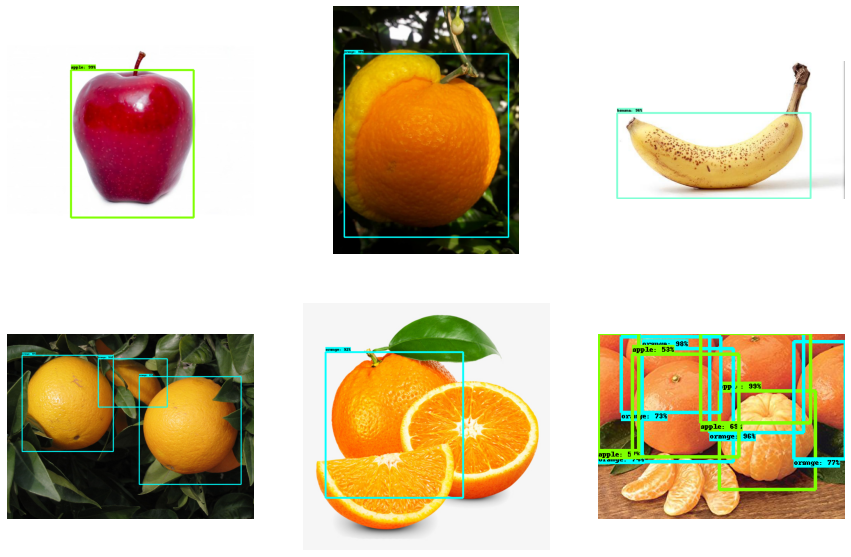

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(15, 10))
for index, image in enumerate(images):
    row, col = int(index / 3), index % 3
    axis[row, col].imshow(image)
    axis[row, col].axis('off')

The model see to perfom quite well, you can try train it on a harder dataset